# Goal: Create the correlation and distance matrices for returns of PSE stocks over different windows

This cell is for importing necessary modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This cell is for reading the data file.

In [2]:
PSE_data = pd.read_csv(
    "C:\\Users\\Donna\\OneDrive - ASIAN INSTITUTE OF MANAGEMENT\\(A) PAPER\\AA Code\\PSE Stocks Data\\daily.csv"
)
PSE_data['date_id'] = pd.to_datetime(PSE_data['date_id'])
PSE_data = PSE_data.set_index("date_id")
df_filtered = PSE_data.drop(columns=[col for col in PSE_data.columns if not (col.startswith('PH_') and col.endswith('_P')) and col != 'date_id'])

This code is for removing the other rows that are not within the last 10 years of the data. I also used the date September 25, 2013 as the start date so that when I calculate log returns, I will have exactly 10 years worth of data. 

In [3]:
df_filtered = df_filtered.loc['2013-09-25':'2023-09-26']
df_filtered

,PH_PIP_P,PH_ASA_P,PH_ABS_P,PH_AGN_P,PH_APC_P,PH_CHP_P,PH_CEU_P,PH_CIR_P,PH_CAA_P,PH_EEQ_P,...,PH_MJC_P,PH_PCK_P,PH_MRP_P,PH_LOT_P,PH_BAG_P,PH_H2O_P,PH_PRC_P,PH_SSN_P,PH_SIN_P,PH_SHK_P
date_id,,,,,,,,,,,,,,,,,,,,,
2013-09-25,NaN,7.0,33.0,6.0,1.0,NaN,11.0,12.0,46.0,10.0,...,1.0,6.0,11.0,6.0,13.0,5.0,10.0,12.0,0.0,NaN
2013-09-26,NaN,6.0,33.0,6.0,1.0,NaN,11.0,12.0,46.0,10.0,...,1.0,6.0,11.0,6.0,12.0,6.0,10.0,11.0,0.0,NaN
2013-09-27,NaN,6.0,33.0,6.0,1.0,NaN,11.0,12.0,46.0,10.0,...,1.0,6.0,11.0,6.0,13.0,5.0,10.0,11.0,0.0,NaN
2013-09-30,NaN,6.0,33.0,6.0,1.0,NaN,11.0,12.0,46.0,10.0,...,1.0,6.0,11.0,6.0,12.0,5.0,10.0,11.0,0.0,NaN
2013-10-01,NaN,7.0,33.0,6.0,1.0,NaN,11.0,12.0,46.0,10.0,...,1.0,6.0,10.0,6.0,13.0,5.0,10.0,11.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,2.0,11.0,3.0,3.0,0.0,1.0,8.0,2.0,44.0,5.0,...,1.0,4.0,7.0,4.0,5.0,1.0,7.0,2.0,1.0,9.0
2023-09-21,2.0,11.0,3.0,3.0,0.0,1.0,8.0,2.0,44.0,5.0,...,1.0,4.0,7.0,4.0,5.0,1.0,7.0,2.0,1.0,9.0
2023-09-22,2.0,11.0,3.0,3.0,0.0,1.0,8.0,2.0,44.0,5.0,...,1.0,4.0,7.0,3.0,5.0,1.0,7.0,2.0,1.0,9.0


## Interpolate over missing data, exclude stocks with excessive missing data

This cell is for excluding stocks with excessive missing data.

In [4]:
def has_high_null_percentage(column, null_threshold):
    return column.isna().mean() > null_threshold

# def has_consecutive_constant_values(column, threshold):
#     constant_streak = column.groupby((column != column.shift()).cumsum()).transform('size')
#     return constant_streak.max() > threshold

# def has_end_constant_values(column, end_threshold):
#     end_section = column.iloc[-int(len(column) * 0.05):]
#     return end_section.nunique() == 1

# def has_few_variations(column, variation_threshold):
#     return column.nunique() < variation_threshold

null_percentage_threshold = 0.85
# consecutive_constant_threshold = int(len(df_filtered) * 0.35) 
# end_constant_threshold = 0.01
# variation_threshold = 50

columns_to_drop = []

for col in df_filtered.columns:
    if col == "date_id":  
        continue
    
    if (
        has_high_null_percentage(df_filtered[col], null_percentage_threshold) # or
        # has_consecutive_constant_values(df_filtered[col], consecutive_constant_threshold) or
        # has_end_constant_values(df_filtered[col], end_constant_threshold) or
        # has_few_variations(df_filtered[col], variation_threshold)
    ):
        columns_to_drop.append(col)

df_filtered = df_filtered.drop(columns=columns_to_drop)

In [5]:
# This cell will just be benchmarked for now.
"""
def has_consecutive_constant_values(column, threshold):
    constant_streak = column.groupby((column != column.shift()).cumsum()).transform('size')
    return constant_streak.max() > threshold

def has_high_null_percentage(column, null_threshold):
    return column.isna().mean() > null_threshold

def has_end_constant_values(column, end_threshold):
    end_section = column.iloc[-int(len(column) * 0.05):]
    return end_section.nunique() == 1

def has_few_variations(column, variation_threshold):
    return column.nunique() < variation_threshold

consecutive_constant_threshold = int(len(df_filtered) * 0.35) 
null_percentage_threshold = 0.5
end_constant_threshold = 0.01
variation_threshold = 50

columns_to_drop = []

for col in df_filtered.columns:
    if col == "date_id":  
        continue
    
    if (
        has_high_null_percentage(df_filtered[col], null_percentage_threshold) or
        has_consecutive_constant_values(df_filtered[col], consecutive_constant_threshold) or
        has_end_constant_values(df_filtered[col], end_constant_threshold) or
        has_few_variations(df_filtered[col], variation_threshold)
    ):
        columns_to_drop.append(col)

df_filtered = df_filtered.drop(columns=columns_to_drop)
"""

'\ndef has_consecutive_constant_values(column, threshold):\n    constant_streak = column.groupby((column != column.shift()).cumsum()).transform(\'size\')\n    return constant_streak.max() > threshold\n\ndef has_high_null_percentage(column, null_threshold):\n    return column.isna().mean() > null_threshold\n\ndef has_end_constant_values(column, end_threshold):\n    end_section = column.iloc[-int(len(column) * 0.05):]\n    return end_section.nunique() == 1\n\ndef has_few_variations(column, variation_threshold):\n    return column.nunique() < variation_threshold\n\nconsecutive_constant_threshold = int(len(df_filtered) * 0.35) \nnull_percentage_threshold = 0.5\nend_constant_threshold = 0.01\nvariation_threshold = 50\n\ncolumns_to_drop = []\n\nfor col in df_filtered.columns:\n    if col == "date_id":  \n        continue\n    \n    if (\n        has_high_null_percentage(df_filtered[col], null_percentage_threshold) or\n        has_consecutive_constant_values(df_filtered[col], consecutive_cons

This cell is for interpolating over missing data.

In [6]:
# storing the old index
original_index = df_filtered.index

In [7]:
df_filtered.index = df_filtered.index.astype(int)

# for i in df_filtered.columns:
#     df_filtered[i] = df_filtered[i].interpolate(method="polynomial", 
#                                                 order=2, inplace=False,
#                                                limit_direction="backward")

for i in df_filtered.columns:    
    if df_filtered[i].isnull().any():
        valid_mask = ~df_filtered[i].isnull()
        valid_time = df_filtered.index[valid_mask]
        valid_values = df_filtered[i][valid_mask]
        
        if len(valid_time) > 1:
            poly_coeff = np.polyfit(valid_time, valid_values, deg=2)
            interpolated_values = np.polyval(poly_coeff, df_filtered.index)
            
            df_filtered[i] = df_filtered[i].combine_first(pd.Series(interpolated_values, index=df_filtered.index))

df_filtered.index = original_index
prices = df_filtered
prices

,PH_ASA_P,PH_ABS_P,PH_AGN_P,PH_APC_P,PH_CHP_P,PH_CEU_P,PH_CIR_P,PH_CAA_P,PH_EEQ_P,PH_FEU_P,...,PH_MJC_P,PH_PCK_P,PH_MRP_P,PH_LOT_P,PH_BAG_P,PH_H2O_P,PH_PRC_P,PH_SSN_P,PH_SIN_P,PH_SHK_P
date_id,,,,,,,,,,,,,,,,,,,,,
2013-09-25,7.0,33.0,6.0,1.0,23.415071,11.0,12.0,46.0,10.0,662.0,...,1.0,6.0,11.0,6.0,13.0,5.0,10.0,12.0,0.0,25.990002
2013-09-26,6.0,33.0,6.0,1.0,23.399059,11.0,12.0,46.0,10.0,645.0,...,1.0,6.0,11.0,6.0,12.0,6.0,10.0,11.0,0.0,25.979028
2013-09-27,6.0,33.0,6.0,1.0,23.383053,11.0,12.0,46.0,10.0,679.0,...,1.0,6.0,11.0,6.0,13.0,5.0,10.0,11.0,0.0,25.968058
2013-09-30,6.0,33.0,6.0,1.0,23.335068,11.0,12.0,46.0,10.0,679.0,...,1.0,6.0,11.0,6.0,12.0,5.0,10.0,11.0,0.0,25.935168
2013-10-01,7.0,33.0,6.0,1.0,23.319084,11.0,12.0,46.0,10.0,679.0,...,1.0,6.0,10.0,6.0,13.0,5.0,10.0,11.0,0.0,25.924211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,11.0,3.0,3.0,0.0,1.000000,8.0,2.0,44.0,5.0,560.0,...,1.0,4.0,7.0,4.0,5.0,1.0,7.0,2.0,1.0,9.000000
2023-09-21,11.0,3.0,3.0,0.0,1.000000,8.0,2.0,44.0,5.0,560.0,...,1.0,4.0,7.0,4.0,5.0,1.0,7.0,2.0,1.0,9.000000
2023-09-22,11.0,3.0,3.0,0.0,1.000000,8.0,2.0,44.0,5.0,565.0,...,1.0,4.0,7.0,3.0,5.0,1.0,7.0,2.0,1.0,9.000000


In [8]:
prices.iloc[:, 1:] = prices.iloc[:, 1:].clip(lower=0).fillna(0)
prices

,PH_ASA_P,PH_ABS_P,PH_AGN_P,PH_APC_P,PH_CHP_P,PH_CEU_P,PH_CIR_P,PH_CAA_P,PH_EEQ_P,PH_FEU_P,...,PH_MJC_P,PH_PCK_P,PH_MRP_P,PH_LOT_P,PH_BAG_P,PH_H2O_P,PH_PRC_P,PH_SSN_P,PH_SIN_P,PH_SHK_P
date_id,,,,,,,,,,,,,,,,,,,,,
2013-09-25,7.0,33.0,6.0,1.0,23.415071,11.0,12.0,46.0,10.0,662.0,...,1.0,6.0,11.0,6.0,13.0,5.0,10.0,12.0,0.0,25.990002
2013-09-26,6.0,33.0,6.0,1.0,23.399059,11.0,12.0,46.0,10.0,645.0,...,1.0,6.0,11.0,6.0,12.0,6.0,10.0,11.0,0.0,25.979028
2013-09-27,6.0,33.0,6.0,1.0,23.383053,11.0,12.0,46.0,10.0,679.0,...,1.0,6.0,11.0,6.0,13.0,5.0,10.0,11.0,0.0,25.968058
2013-09-30,6.0,33.0,6.0,1.0,23.335068,11.0,12.0,46.0,10.0,679.0,...,1.0,6.0,11.0,6.0,12.0,5.0,10.0,11.0,0.0,25.935168
2013-10-01,7.0,33.0,6.0,1.0,23.319084,11.0,12.0,46.0,10.0,679.0,...,1.0,6.0,10.0,6.0,13.0,5.0,10.0,11.0,0.0,25.924211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,11.0,3.0,3.0,0.0,1.000000,8.0,2.0,44.0,5.0,560.0,...,1.0,4.0,7.0,4.0,5.0,1.0,7.0,2.0,1.0,9.000000
2023-09-21,11.0,3.0,3.0,0.0,1.000000,8.0,2.0,44.0,5.0,560.0,...,1.0,4.0,7.0,4.0,5.0,1.0,7.0,2.0,1.0,9.000000
2023-09-22,11.0,3.0,3.0,0.0,1.000000,8.0,2.0,44.0,5.0,565.0,...,1.0,4.0,7.0,3.0,5.0,1.0,7.0,2.0,1.0,9.000000


<function matplotlib.pyplot.show(close=None, block=None)>

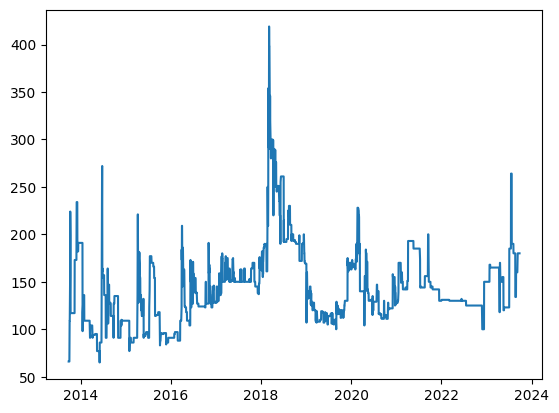

In [9]:
plt.plot(prices["PH_CIP_P"])
plt.show

## Calculate returns from raw prices; log returns are probably easier, but you can try others like standardized returns if you have time

This cell is for calculating log returns.

In [10]:
PSE_log_returns = df_filtered.copy()

for col in PSE_log_returns.columns:
    if col == "date_id":
        continue
        
    PSE_log_returns[col] = np.log(PSE_log_returns[col]/PSE_log_returns[col].shift(1))

C:\Users\Donna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


I removed the the row for September 25, 2013, and I filled all the nan values with zero.

In [11]:
PSE_log_returns = PSE_log_returns.loc['2013-09-26':'2023-09-26']
PSE_log_returns.fillna(0)

,PH_ASA_P,PH_ABS_P,PH_AGN_P,PH_APC_P,PH_CHP_P,PH_CEU_P,PH_CIR_P,PH_CAA_P,PH_EEQ_P,PH_FEU_P,...,PH_MJC_P,PH_PCK_P,PH_MRP_P,PH_LOT_P,PH_BAG_P,PH_H2O_P,PH_PRC_P,PH_SSN_P,PH_SIN_P,PH_SHK_P
date_id,,,,,,,,,,,,,,,,,,,,,
2013-09-26,-0.154151,0.0,0.0,0.0,-0.000684,0.0,0.0,0.0,0.0,-0.026015,...,0.0,0.0,0.00000,0.000000,-0.080043,0.182322,0.0,-0.087011,0.0,-0.000422
2013-09-27,0.000000,0.0,0.0,0.0,-0.000684,0.0,0.0,0.0,0.0,0.051371,...,0.0,0.0,0.00000,0.000000,0.080043,-0.182322,0.0,0.000000,0.0,-0.000422
2013-09-30,0.000000,0.0,0.0,0.0,-0.002054,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,-0.080043,0.000000,0.0,0.000000,0.0,-0.001267
2013-10-01,0.154151,0.0,0.0,0.0,-0.000685,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,-0.09531,0.000000,0.080043,0.000000,0.0,0.000000,0.0,-0.000423
2013-10-02,0.000000,0.0,0.0,0.0,-0.000685,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,-0.000423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2023-09-21,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2023-09-22,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.008889,...,0.0,0.0,0.00000,-0.287682,0.000000,0.000000,0.0,0.000000,0.0,0.000000


## Find an appropriate window size over which to calculate any given correlation matrix (literature suggests 3-6 months is typical, but double check). Construct the correlation matrix between returns for all valid stocks in each window. We have \~10 years of data (\~200 trading days per year), so this should make ~2000 windows.

This is for creating the correlation matrix. I used a window size of 3 months.

In [12]:
# correl_df = pd.DataFrame(columns=PSE_log_returns.columns).reset_index()

# for col in PSE_log_returns.columns:
#     correl_df[col] = PSE_log_returns[col].rolling(window=90).max()

# correl_df.reset_index()

In [13]:
correl_matrix = pd.DataFrame(index=PSE_log_returns.columns, columns=PSE_log_returns.columns)

for col1 in PSE_log_returns.columns:
    for col2 in PSE_log_returns.columns:
        if col1 != col2:
            # to_compare = PSE_log_returns[col2].rolling(window=180)
            rolling_corr = PSE_log_returns[col1].rolling(window=180).corr(PSE_log_returns[col2])            
            correl_matrix.loc[col1, col2] = rolling_corr.iloc[-1]

In [14]:
# Display the resulting correlation matrix
correl_matrix = correl_matrix.astype(float).fillna(0)
correl_matrix

,PH_ASA_P,PH_ABS_P,PH_AGN_P,PH_APC_P,PH_CHP_P,PH_CEU_P,PH_CIR_P,PH_CAA_P,PH_EEQ_P,PH_FEU_P,...,PH_MJC_P,PH_PCK_P,PH_MRP_P,PH_LOT_P,PH_BAG_P,PH_H2O_P,PH_PRC_P,PH_SSN_P,PH_SIN_P,PH_SHK_P
PH_ASA_P,0.000000,-0.146844,0.003460,0.0,0.0,0.067906,0.001276,-0.171624,-0.001871,-0.007554,...,0.000000,0.002215,0.0,-0.001778,0.258256,0.0,-0.000346,0.002215,0.0,-0.092693
PH_ABS_P,-0.146844,0.000000,0.046541,0.0,0.0,0.001168,-0.003463,-0.093871,0.005076,-0.057790,...,0.000000,-0.006009,0.0,0.127213,-0.052425,0.0,0.068044,-0.006009,0.0,0.158659
PH_AGN_P,0.003460,0.046541,0.000000,0.0,0.0,0.097924,-0.005029,0.004558,0.007372,-0.020062,...,0.000000,-0.008727,0.0,0.007007,0.054649,0.0,0.142440,-0.008727,0.0,-0.067904
PH_APC_P,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
PH_CHP_P,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PH_H2O_P,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
PH_PRC_P,-0.000346,0.068044,0.142440,0.0,0.0,-0.000170,0.000503,-0.000502,0.057233,0.066922,...,0.000000,-0.184938,0.0,0.315127,-0.078262,0.0,0.000000,0.000873,0.0,-0.032699
PH_SSN_P,0.002215,-0.006009,-0.008727,0.0,0.0,0.001086,-0.003219,-0.146282,0.004719,0.000956,...,0.000000,-0.005587,0.0,0.004486,-0.001278,0.0,0.000873,0.000000,0.0,0.001292
PH_SIN_P,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
